<a href="https://colab.research.google.com/github/RowenYaparto/Machine-Learning-2022/blob/main/Prediksi_Penyakit_Lardiovaskular_menggunakan_KNN_dan_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Brad Rowen Yaparto
Nim : H071201078

#**Supervised Learning**

In [2]:
!pip install seaborn --upgrade
import pandas as pd # data manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot # normality check
import plotly.express as px
from sklearn.tree import plot_tree # decision tree 

# data preprocessing
from imblearn.over_sampling import SMOTE # deal with imbalance data
from sklearn.preprocessing import MinMaxScaler, PowerTransformer # scale data

# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression # linear classification


# model evaluation and selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


 ## Dataset dan Deskripsi Fitur 

In [3]:
df = pd.read_csv('/content/heart_failure_clinical_records_dataset (1).csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.shape   # dimensi data

(299, 13)

In [5]:
df.info()  # info struktur data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
df.age = df.age.astype('int64')  # Perbaiki tipe data usia 

In [7]:
# mempersiapkan data numerik dan kategori
numeric = ['age', 'creatinine_phosphokinase', 
           'ejection_fraction', 'platelets', 
           'serum_creatinine', 'time']
categorical = ['anaemia', 'diabetes', 'high_blood_pressure', 
               'sex', 'smoking']

## Missing Values

- Tidak ada nilai yang hilang 

In [8]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

##Check Variabel Targets 

- Kelas atau label target tidak seimbang 

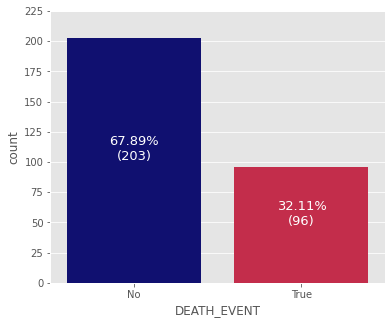

In [9]:
target_count = df.DEATH_EVENT.value_counts()
death_color = ['navy', 'crimson']
with plt.style.context('ggplot'):
    plt.figure(figsize=(6, 5))
    sns.countplot(data=df, x='DEATH_EVENT', palette=death_color)
    for name , val in zip(target_count.index, target_count.values):
        plt.text(name, val/2, f'{round(val/sum(target_count)*100, 2)}%\n({val})', ha='center',
                color='white', fontdict={'fontsize':13})
    plt.xticks(ticks=target_count.index, labels=['No', 'True'])
    plt.yticks(np.arange(0, 230, 25))
    plt.show()

##Distribusi Fitur Numerik

- Dengan memperhatikan grafik histogram variabel numeriknya, diketahui bahwa fitur `creatinine_phosphokinase` dan `serum_creatinine` sangat positif atau miring ke kanan 

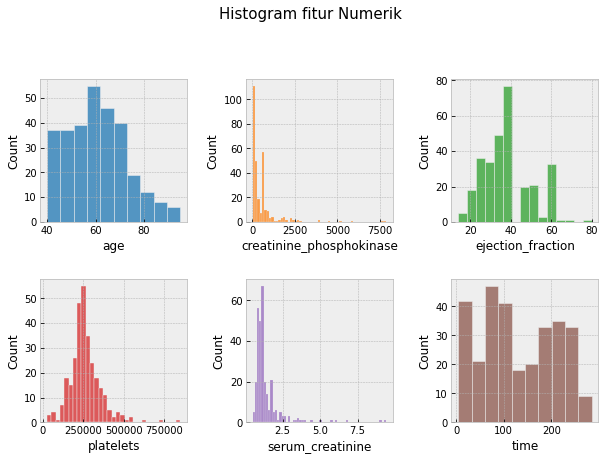

In [10]:
colors = sns.color_palette("tab10")
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for i, (col, name) in enumerate(zip(colors, numeric)):
        plt.subplot(3, 3, i+1)
        sns.histplot(data=df, x=name, color=col)
    plt.suptitle('Histogram fitur Numerik', fontsize=15)

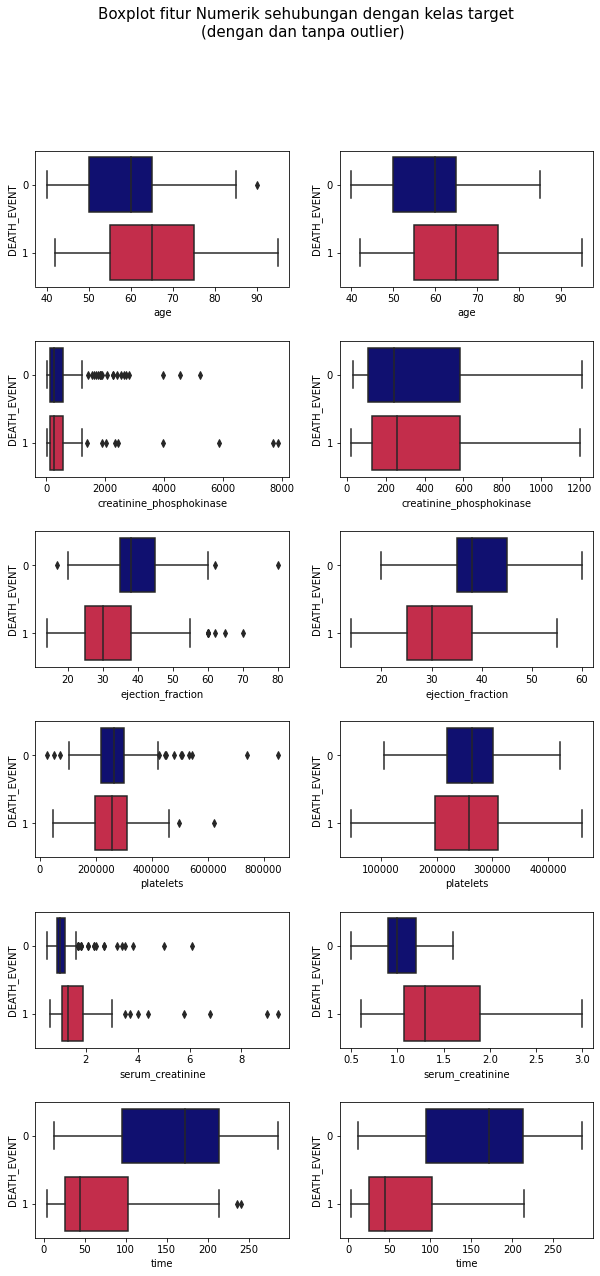

In [11]:
fig, axes = plt.subplots(6, 2, figsize=(10, 20))
plt.subplots_adjust(hspace=0.4)
axes = axes.ravel()
for i, name, col in zip(np.arange(0, 14, 2), numeric, colors):
    sns.boxplot(data=df, x=name, ax=axes[i], y='DEATH_EVENT', 
                orient='h', palette=death_color, showfliers=True)
    sns.boxplot(data=df, x=name, ax=axes[i+1], y='DEATH_EVENT', 
                orient='h', palette=death_color, showfliers=False)
plt.suptitle('Boxplot fitur Numerik sehubungan dengan kelas target\n(dengan dan tanpa outlier) ', 
             fontsize=15)
plt.show()

##Fitur Kategoris Distribusi Dengan Kelas Target

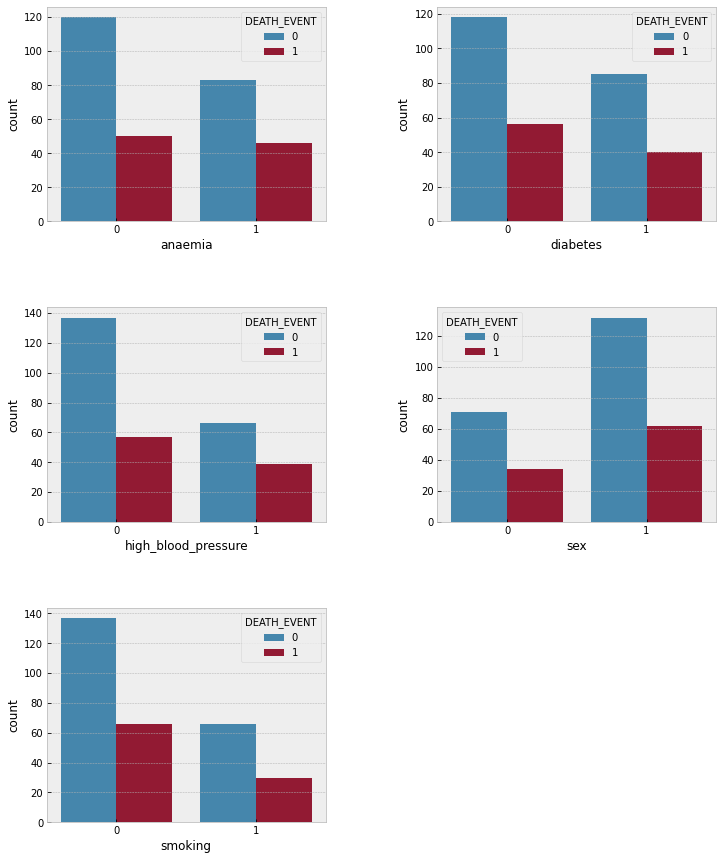

In [12]:
colors = sns.color_palette("tab10")
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 15))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    for i, (col, name) in enumerate(zip(colors, categorical)):
        plt.subplot(3, 2, i+1)
        sns.countplot(data=df, x=name, hue='DEATH_EVENT')

# Manipulasi Data
     

 Pisahkan Fitur dan Kelas Target  

In [13]:
X = df.iloc[:, :-1]
y = df['DEATH_EVENT']
print(X.shape)
print(y.shape)

(299, 12)
(299,)


##  Perbaiki Ketidakseimbangan Kelas menggunakan SMOTE

SMOTE adalah teknik oversampling di mana sampel sintetis dihasilkan untuk kelas minoritas, dalam kasus ini, 1's 

In [14]:
smote = SMOTE(random_state=2021, n_jobs=-1, k_neighbors=5)
smote.fit(X, y)
X_smote, y_smote = smote.fit_resample(X, y)
print(X_smote.shape)
print(y_smote.shape)

(406, 12)
(406,)


## Transformasi Data

Selama EDA untuk fitur numerik, histogram dari beberapa fitur menunjukkan kemiringan. Beberapa fitur seperti `creatinine_phosphokinase` dan `serum_creatinine` sangat miring. Fitur miring seperti ini dapat dibuat lebih mirip Gaussian menggunakan transformasi daya atau transformasi log. Sebagai contoh:



**1. creatinine_phosphokinase** menggunakan transformasi log dapat membuat data sesuai dengan normalitas. Dalam hal ini, log-transform menghilangkan atau mengurangi skewness karena data asli mengikuti distribusi log-normal atau kira-kira begitu. 

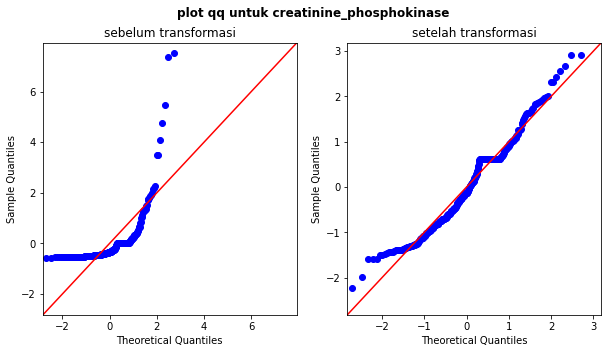

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
qqplot(df.creatinine_phosphokinase, fit=True, line='45', ax=ax[0])
ax[0].set_title('sebelum transformasi')
qqplot(np.log10(df.creatinine_phosphokinase), fit=True, line='45', ax=ax[1])
ax[1].set_title('setelah transformasi')
plt.suptitle('plot qq untuk creatinine_phosphokinase', fontweight='bold')
plt.show()

Plot qq di atas menunjukkan pengaruh transformasi log pada kreatinin_fosfokinase. Plot QQ (atau plot kuantil-kuantil) adalah plot di mana sumbu sengaja diubah untuk membuat distribusi normal (atau Gaussian) muncul dalam garis lurus. Dengan kata lain, distribusi normal sempurna akan mengikuti garis dengan kemiringan = 1 dan intersep = 0. 

**2. serum_creatinine** menggunakan transformasi resiprokal (p = -1). Transformasi ini memiliki efek radikal karena membalikkan urutan di antara nilai-nilai dari tanda yang sama, oleh karena itu, nilai yang lebih besar menjadi lebih kecil, dan sebaliknya.

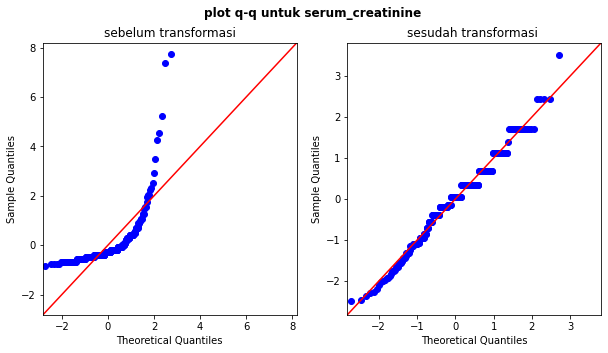

In [16]:
p = -1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

qqplot(df.serum_creatinine, fit=True, line='45', ax=ax[0])
ax[0].set_title('sebelum transformasi')

qqplot(df.serum_creatinine**p, fit=True, line='45', ax=ax[1])
ax[1].set_title('sesudah transformasi ')

plt.suptitle('plot q-q untuk serum_creatinine', fontweight='bold')
plt.show()

Power Transformer dari paket sklearn-learn menyediakan dua metode untuk membuat distribusi seperti gaussian
- Boxcox
- Yeo-johnson

Kedua metode ini mencari nilai p yang tepat (seperti pada contoh di atas) agar distribusinya menjadi normal. Yeo-johnson adalah versi upgrade dari Boxcox karena berurusan dengan data dengan nilai negatif 

In [17]:
pt = PowerTransformer(method='yeo-johnson')
X_pt = pt.fit_transform(X_smote)
X_pt

array([[ 1.0270975 , -0.78583069,  0.66513694, ...,  0.80647784,
        -0.59062442, -2.09224159],
       [-0.58656988, -0.78583069,  2.55729366, ...,  0.80647784,
        -0.59062442, -1.97807977],
       [ 0.26608504, -0.78583069, -0.60636642, ...,  0.80647784,
         1.69312335, -1.9274372 ],
       ...,
       [ 0.10368013,  1.27253874,  0.53713399, ..., -1.23995968,
        -0.59062442, -1.23081612],
       [ 1.91177672,  1.27253874, -0.74622526, ...,  0.80647784,
        -0.59062442, -0.95808655],
       [-0.67793462,  1.27253874, -0.4004775 , ...,  0.80647784,
        -0.59062442, -1.67628156]])

## Normalisasi Data

Terakhir, normalkan data menggunakan min-max scaler yang menskalakan data ke kisaran 0-1. Penskalaan diperlukan untuk ML juga seperti SVM, regresi logistik, knn yang sensitif terhadap penskalaan dan outlier (berlaku untuk masalah klasifikasi dan regresi). 

In [18]:
mm = MinMaxScaler()
X_scaled = mm.fit_transform(X_pt)

##Distribusi Fitur Setelah Transformasi dan Penskalaan 

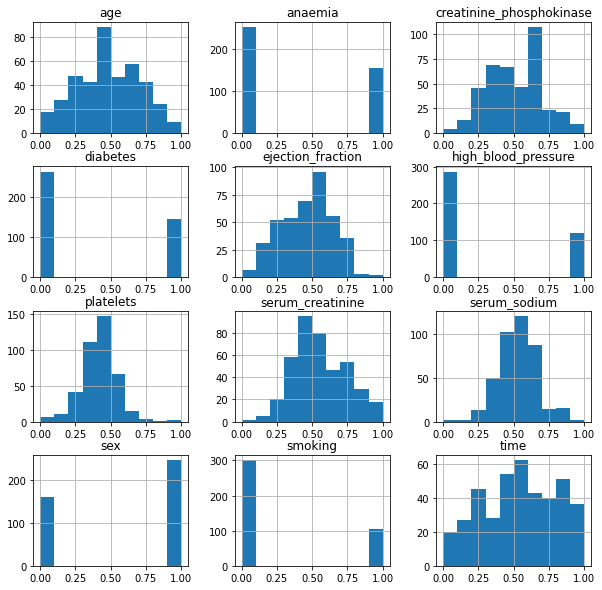

In [19]:
pd.DataFrame(X_scaled, columns=X.columns).hist(figsize=(10, 10))
plt.show()

##  Seleksi Fitur menggunakan Random Forest  

In [20]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, 
                            class_weight='balanced', random_state=2021)
rf.fit(X_scaled, y_smote)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_jobs=-1,
                       random_state=2021)

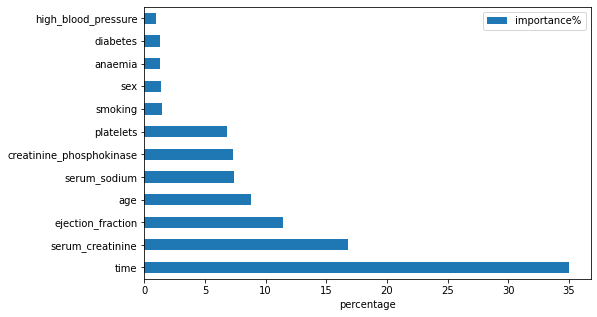

In [21]:
feature_imp = pd.DataFrame(np.round(rf.feature_importances_*100, 2), index=X.columns, columns=['importance%'])
feature_imp = feature_imp.sort_values(by='importance%', ascending=False)
feature_imp.plot(kind='barh', figsize=(8, 5))
plt.xlabel('percentage')
plt.show()

In [22]:
imp_features = feature_imp.index[:3]
imp_features

Index(['time', 'serum_creatinine', 'ejection_fraction'], dtype='object')

In [23]:
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[imp_features]
X_selected

,time,serum_creatinine,ejection_fraction
0,0.000000,0.737676,0.165986
1,0.029502,0.489581,0.512213
2,0.042589,0.575762,0.165986
3,0.042589,0.737676,0.165986
4,0.054846,0.845279,0.165986
...,...,...,...
401,0.142785,0.527085,0.542704
402,0.142785,0.856704,0.319941
403,0.222609,0.436728,0.557539
404,0.293088,0.492972,0.641457


#  Pemodelan Data dan Hyperparameter

Oleh karena itu, tujuannya sekarang adalah untuk memisahkan kedua kelas seperti yang ditunjukkan pada gambar di bawah ini

Semua pengklasifikasi telah disetel untuk memaksimalkan skor f1 alih-alih akurasi. Skor F1 adalah rata-rata harmonik dari recall dan presisi. Skor ini akan mendukung pengklasifikasi dengan presisi dan daya ingat yang sama. Saya bisa saja mencapai daya ingat atau presisi yang tinggi tetapi sayangnya, kita tidak dapat memilikinya dua arah karena meningkatkan presisi mengurangi daya ingat, dan sebaliknya. 

In [24]:
model_data = X_selected
model_data['target'] = y_smote
model_data

,time,serum_creatinine,ejection_fraction,target
0,0.000000,0.737676,0.165986,1
1,0.029502,0.489581,0.512213,1
2,0.042589,0.575762,0.165986,1
3,0.042589,0.737676,0.165986,1
4,0.054846,0.845279,0.165986,1
...,...,...,...,...
401,0.142785,0.527085,0.542704,1
402,0.142785,0.856704,0.319941,1
403,0.222609,0.436728,0.557539,1
404,0.293088,0.492972,0.641457,1


In [25]:
px.scatter_3d(model_data, x='time', y='serum_creatinine', z='ejection_fraction', color='target')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(model_data.drop(['target'], axis=1), 
                                                    model_data['target'], 
                                                    test_size=0.20, 
                                                    random_state=2021, 
                                                    stratify=model_data['target']
                                                   )
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(324, 3)
(324,)
(82, 3)
(82,)


## k-Nearest Neighbor Classifier

Mari kita mulai dengan pelajar yang sederhana dan malas di mana suatu objek diklasifikasikan berdasarkan suara pluralitas tetangganya. 

In [27]:
knn_clf = KNeighborsClassifier(n_jobs=-1)

# Penyetelan hiperparameter 

knn_params = {
    'n_neighbors': np.arange(2, 12)
}
knn_cv = GridSearchCV(knn_clf, knn_params, scoring='f1', n_jobs=-1, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
             scoring='f1')

### Nilai Optimal untuk Memaksimalkan Kinerja

Oleh karena itu, skor f1 tertinggi dicapai dengan knn menggunakan 6 tetangga. 

In [28]:
knn_cv.best_params_

{'n_neighbors': 6}

### Prediksi pada data pelatihan menggunakan prediksi lintas Val

cross_val_predict() melakukan validasi silang K-fold, tetapi alih-alih mengembalikan skor evaluasi, ia mengembalikan prediksi yang dibuat pada setiap lipatan tes (iterasi). Ini berarti Anda mendapatkan prediksi yang jelas untuk setiap instance dalam set pelatihan. 

In [29]:
knn_train_pred = cross_val_predict(knn_cv, X_train, y_train, cv=10, n_jobs=-1)
knn_train_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,

### Laporan Klasifikasi data pelatihan 

In [30]:
print(classification_report(y_train, knn_train_pred, digits=4, target_names=['not gonna die', 'will die']))

               precision    recall  f1-score   support

not gonna die     0.8662    0.8395    0.8527       162
     will die     0.8443    0.8704    0.8571       162

     accuracy                         0.8549       324
    macro avg     0.8553    0.8549    0.8549       324
 weighted avg     0.8553    0.8549    0.8549       324



## Regresi Logistik

Regresi logistik menggunakan fungsi logit untuk menghitung probabilitas hasil, dalam kasus kami, kelas target `` 

In [31]:
lr_clf = LogisticRegression(class_weight='balanced', random_state=2021, n_jobs=-1)

In [32]:
# Penyetelan hyper-parameter menggunakan Pencarian Grid 
lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    #'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
lr_cv = GridSearchCV(lr_clf, lr_params, scoring='f1', cv=10, n_jobs=-1)
lr_cv.fit(X_train, y_train)

# Nilai parameter terbaik untuk mencapai skor F1 tertinggi 
lr_cv.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


160 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solve

{'C': 1, 'penalty': 'l2'}

In [33]:
# Prediksi pada data pelatihan menggunakan prediksi nilai silang
lr_train_pred = cross_val_predict(lr_cv, X_train, y_train, cv=10, n_jobs=-1)

# Laporan klasifikasi
print(classification_report(y_train, lr_train_pred, digits=4, target_names=['not gonna die', 'will die']))

               precision    recall  f1-score   support

not gonna die     0.8373    0.8580    0.8476       162
     will die     0.8544    0.8333    0.8438       162

     accuracy                         0.8457       324
    macro avg     0.8459    0.8457    0.8457       324
 weighted avg     0.8459    0.8457    0.8457       324



# Kesimpulan

Model yang terbaik untuk melakukan klasifikasi untuk dataset ini adalah KNN.

